In [1]:
%cd /home/ubuntu/eda/flood-risk/modeling/data
from osgeo import gdal, gdal_array, osr, ogr
import numpy as np
import rasterio
from rasterio import mask
import pyproj
from affine import Affine
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from rasterio.features import shapes
import xarray
import matplotlib.pyplot as plt
import rtree
import shapely
import warnings
import time
from scipy.cluster.hierarchy import dendrogram


from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, AffinityPropagation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# import hdbscan

warnings.filterwarnings('ignore')

[Errno 2] No such file or directory: '/home/ubuntu/eda/flood-risk/modeling/data'
/Users/grantwilson/mids/flood-risk/modeling


ModuleNotFoundError: No module named 'osgeo'

#### High Water Mark

In [2]:
hw = pd.read_csv('./FilteredHWMs_Ida.csv')
hw.columns = hw.columns.str.lower()
hw = hw[hw.eventname == '2021 Ida']
hw = gpd.GeoDataFrame(hw[['eventname','hwmtypename', 'site_no', 'sitedescription','site_latitude', 'site_longitude', 'hwm_id','waterbody', 'site_id', 'hwm_type_id', 'hwm_quality_id','hwm_locationdescription', 'survey_date', 'elev_ft','height_above_gnd','hwm_notes', 'flag_date', 'stillwater','uncertainty','hwm_label']], 
                      geometry = gpd.points_from_xy(hw['longitude_dd'],hw['latitude_dd'])).set_crs(4326).to_crs(2263)
hw = hw[['eventname','hwm_id','site_no','site_latitude','site_longitude','waterbody','survey_date','elev_ft','height_above_gnd','stillwater','geometry']].sort_values(by = ['site_no','height_above_gnd'], ascending = False).groupby('site_no').head(1)

In [3]:
hw.describe()

hwm_id  site_latitude  site_longitude     elev_ft  \
count     83.000000      83.000000       83.000000   83.000000   
mean   41233.590361      40.724783      -73.929262   40.631325   
std      244.782484       0.078262        0.103482   38.800185   
min    40946.000000      40.589173      -74.156753    3.700000   
25%    40993.000000      40.672010      -73.985231   15.600000   
50%    41183.000000      40.718217      -73.900633   29.800000   
75%    41444.500000      40.761889      -73.847039   58.100000   
max    41679.000000      40.894233      -73.765239  240.700000   

       height_above_gnd  stillwater  
count         79.000000   83.000000  
mean           1.999620    0.132530  
std            1.525491    0.341127  
min            0.000000    0.000000  
25%            0.925000    0.000000  
50%            1.630000    0.000000  
75%            2.435000    0.000000  
max            6.510000    1.000000

#### Sandy Inundation

In [4]:
sd = gpd.read_file('./sandy_inundation.shp').set_crs(4326).to_crs(2263)

In [5]:
sd.head()

geometry
0  POLYGON ((918494.320 128523.034, 918492.192 12...
1  POLYGON ((948808.195 138356.716, 948810.318 13...
2  POLYGON ((1009053.467 160146.572, 1009051.883 ...
3  POLYGON ((975521.372 160027.088, 975517.667 16...
4  POLYGON ((989512.654 160750.173, 989515.302 16...

In [5]:
%cd /home/ubuntu/eda/data

/home/ubuntu/eda/data


#### NYC Features

In [6]:
ny = pd.read_csv('./ny_full_scaled.csv')
ny = gpd.GeoDataFrame(ny, geometry = ny['geometry'].apply(shapely.wkt.loads)).drop(columns = ['Unnamed: 0'])
ny.head()

cb2020  borocode   boroname  ct2020    bctcb2020            geoid  \
0    1000         1  Manhattan     100  10001001000  360610001001000   
1    1001         1  Manhattan     100  10001001001  360610001001001   
2    1000         1  Manhattan     201  10002011000  360610002011000   
3    1001         1  Manhattan     201  10002011001  360610002011001   
4    2000         1  Manhattan     201  10002012000  360610002012000   

   shape_leng  shape_area                                           geometry  \
0    2.563287    1.028343  POLYGON ((973172.666 194632.348, 973310.630 19...   
1    1.328588    0.436533  POLYGON ((972081.788 190733.467, 972184.766 19...   
2   -0.234124   -0.099464  POLYGON ((988376.731 199328.618, 987837.811 19...   
3   -0.220366   -0.088884  POLYGON ((988392.400 199070.298, 988285.301 19...   
4    0.034592    0.041155  POLYGON ((988422.186 198807.188, 988449.289 19...   

   land_cvr_1  ...  rw_length  rw_avg_elev  lake_res_ind  pond_ind  river_ind  \
0    0.572610  ...  -0.109035    -0.197793             0         0          1   
1    0.232433  ...  -0.109035    -0.197793             0         0          0   
2   -0.545577  ...  -0.109035    -0.197793             0         0          0   
3    0.030490  ...  -0.109035    -0.197793             0         0          0   
4    3.077870  ...  -0.109035    -0.197793             0         0          0   

   stream_ind  wl_marsh_ind beach_shore_ind  bay_ocean_ind  elev_mean_diff  
0           0             0               0              1       -0.103761  
1           0             0               1              1        0.168386  
2           0             0               0              0        0.699072  
3           0             0               0              0        0.603821  
4           0             0               0              0        0.318067  

[5 rows x 51 columns]

In [8]:
#geo feats and Ida high water marks
ny_hw = ny.sjoin(hw[['elev_ft','height_above_gnd','geometry']], how = 'inner', predicate = 'contains').sort_values(by = ['bctcb2020','height_above_gnd']).groupby('bctcb2020').head(1).drop(columns = ['index_right','cb2020','borocode','boroname','ct2020','geoid','geometry','ntaname']).set_index('bctcb2020')
ny_hw.head()

shape_leng  shape_area  land_cvr_1  land_cvr_2  land_cvr_3  \
bctcb2020                                                                 
10143001001    5.026400    3.275649    1.694165    1.827652    0.972171   
10287001006   -0.360039   -0.117529   -0.558164   -0.769017   -0.092682   
10297001003    6.432535    6.325506    4.778986    0.126734    0.313258   
20046001008   -0.150070   -0.050504    2.859273    0.153450   -0.092682   
20132005003    0.065932   -0.010251   -0.997238   -0.096887   -0.092682   

             land_cvr_4  land_cvr_5  land_cvr_6  land_cvr_7  land_cvr_8  ...  \
bctcb2020                                                                ...   
10143001001    2.239673   -1.641641   -0.844516   -1.388076   -0.189784  ...   
10287001006   -0.085076    0.860806   -0.001411    0.329599   -0.189784  ...   
10297001003   -0.058824   -1.666643   -1.048150   -1.986473   -0.189784  ...   
20046001008   -0.085076   -0.939228   -0.869277   -0.826934   -0.189784  ...   
20132005003   -0.085076   -0.024506    0.121026    1.244447   -0.189784  ...   

             lake_res_ind  pond_ind  river_ind  stream_ind  wl_marsh_ind  \
bctcb2020                                                                  
10143001001             1         0          0           0             0   
10287001006             0         0          0           0             0   
10297001003             0         0          1           0             0   
20046001008             0         0          0           0             0   
20132005003             0         0          0           0             0   

             beach_shore_ind  bay_ocean_ind  elev_mean_diff  elev_ft  \
bctcb2020                                                              
10143001001                0              0       -2.709566     14.4   
10287001006                0              0       -4.437698     20.9   
10297001003                0              0        1.352224      6.9   
20046001008                0              0       -0.069743      8.6   
20132005003                0              0       -0.233031     10.0   

             height_above_gnd  
bctcb2020                      
10143001001              0.00  
10287001006              1.95  
10297001003              0.00  
20046001008              0.34  
20132005003              1.70  

[5 rows x 45 columns]

#### RF Ida Watermarks

In [9]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw.iloc[:,:-2], ny_hw.iloc[:,-2], test_size = 0.2, random_state = 25)

params = {
    'n_estimators':[150,200,250,300],
    'max_depth':[None, 8, 6, 4, 3],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best params:RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42)
Train set R2: 0.5675036084171327


In [10]:
rf = RandomForestRegressor(max_depth = 4, n_estimators = 300, random_state = 42, max_features = 'sqrt', min_samples_leaf = 2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.4639213329348202


In [12]:
pd.DataFrame(rf.feature_importances_, index = rf.feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

importance
elev_q1                0.117887
elev_min               0.108168
elev_q1_ct             0.098714
elev_q3                0.097541
elev_mean              0.081244
elev_min_ct            0.080158
elev_max               0.063833
elev_mean_ct           0.060840
elev_q3_ct             0.043041
elev_max_ct            0.029258
land_cvr_2_ct          0.021917
land_cvr_5_ct          0.017086
elev_mean_diff         0.015699
land_cvr_5             0.014778
land_cvr_2             0.013985
land_cvr_6             0.013037
land_cvr_7_ct          0.012867
elev_var_ct            0.011542
land_cvr_1_ct          0.011376
land_cvr_6_ct          0.011265
elev_var               0.010684
shape_area             0.010594
land_cvr_1             0.010295
catch_basin_count      0.009960
land_cvr_7             0.008605
shape_leng             0.007819
catch_basin_density    0.004124
land_cvr_3_ct          0.003573
land_cvr_3             0.002667
land_cvr_8_ct          0.002017
land_cvr_8             0.001465
rw_length              0.001398
land_cvr_4_ct          0.001086
river_ind              0.000707
land_cvr_4             0.000484
rw_avg_elev            0.000270
pond_ind               0.000019
sub_entr_count         0.000000
lake_res_ind           0.000000
stream_ind             0.000000
wl_marsh_ind           0.000000
beach_shore_ind        0.000000
bay_ocean_ind          0.000000

### Binary Sandy Inundation

# Unsupervised

#### Determine # of Clusters

In [7]:
feat_cols = ['land_cvr_1', 'land_cvr_2',
        'land_cvr_5', 'land_cvr_6', 'land_cvr_7',
         'land_cvr_1_ct', 'land_cvr_2_ct',
        'land_cvr_5_ct', 'land_cvr_6_ct',
       'land_cvr_7_ct',  'elev_mean', 'elev_min', 'elev_max',
       'elev_q1', 'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct',
       'elev_max_ct', 'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct',
       'catch_basin_count', 'catch_basin_density', 
       'elev_mean_diff']

In [8]:
feat_subset = [
    # 'land_cvr_2',
        # 'land_cvr_5', 
               # 'land_cvr_6',
          'land_cvr_2_ct',
        'land_cvr_5_ct', 
       # 'land_cvr_7_ct',  
               # 'elev_mean', 
               # 'elev_min', 
               # 'elev_max',
       'elev_q1', 
               'elev_q3', 
               # 'elev_mean_ct', 
               # 'elev_min_ct',
        'elev_q1_ct' 
               # ,'elev_q3_ct'
              ]

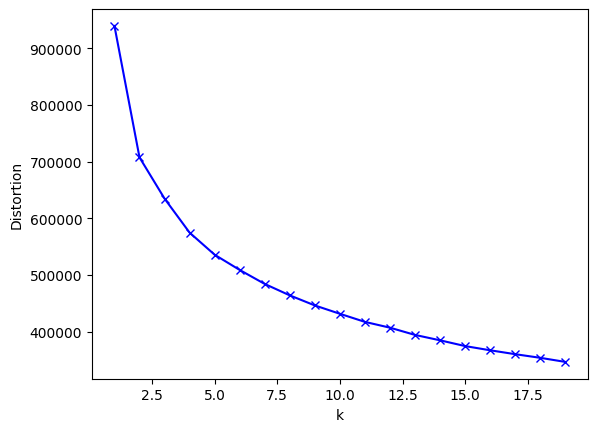

In [17]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_cols])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

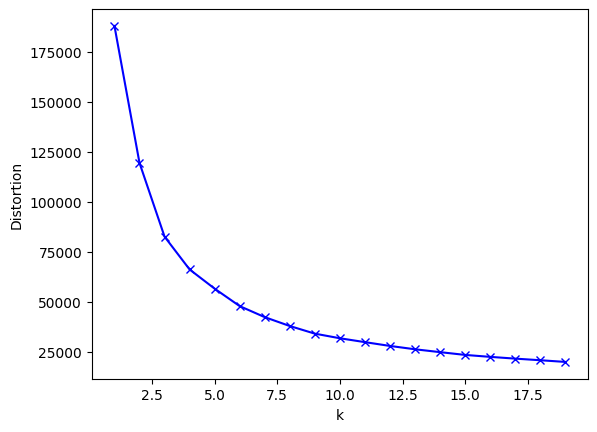

In [29]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_subset])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [9]:
#range: [-1,1], 1 is best, close to 0 indicates overlapping clusters, negative indicates values assigned to wrong cluster
def cv_silhouette_score(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [31]:
# ny.columns

# Clustering Methods

In [10]:
feat_data = ny.set_index('bctcb2020').drop(columns = ['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname'])

In [11]:
def model_train_eval(model_obj, X, cv = False, params = None):

    model = model_obj.fit(X)
        # core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
        # core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

### Agglomerative

In [57]:
n_clusters = [5,6,7]
for n in n_clusters:
    ac = AgglomerativeClustering(n_clusters = n)
    model_train_eval(ac, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.288
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.291
---------------
Estimated number of clusters: 7
Estimated number of noise points: 0
Silhouette Coefficient: 0.221
---------------


### DBSCAN

In [54]:
eps =[0.5,0.75,1,1.25]
min_samples = [5,8,10]
for e in eps:
    for m in min_samples:
        print(f'Max dist:{e}, min samples:{m}')
        model_train_eval(DBSCAN(eps = e, min_samples = m), feat_data[feat_subset], cv = True, params = params)
        print('-'*15)

Max dist:0.5, min samples:5
Estimated number of clusters: 54
Estimated number of noise points: 298
Silhouette Coefficient: -0.101
---------------
Max dist:0.5, min samples:8
Estimated number of clusters: 36
Estimated number of noise points: 563
Silhouette Coefficient: -0.059
---------------
Max dist:0.5, min samples:10
Estimated number of clusters: 28
Estimated number of noise points: 753
Silhouette Coefficient: -0.052
---------------
Max dist:0.75, min samples:5
Estimated number of clusters: 24
Estimated number of noise points: 72
Silhouette Coefficient: 0.238
---------------
Max dist:0.75, min samples:8
Estimated number of clusters: 19
Estimated number of noise points: 129
Silhouette Coefficient: 0.239
---------------
Max dist:0.75, min samples:10
Estimated number of clusters: 17
Estimated number of noise points: 184
Silhouette Coefficient: 0.279
---------------
Max dist:1, min samples:5
Estimated number of clusters: 7
Estimated number of noise points: 19
Silhouette Coefficient: 0.34

#### KMeans

In [56]:
n_clusters = [5,6,7]
for n in n_clusters:
    km = KMeans(n_clusters = n)
    model_train_eval(km, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.347
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.341
---------------
Estimated number of clusters: 7
Estimated number of noise points: 0
Silhouette Coefficient: 0.329
---------------


### Affinity Propagation

In [ ]:
damping = [0.5, 0.65, 0.8, 0.95]
for d in damping:
    print(f'Damping factor:{d}')
    ap = AffinityPropagation(damping = d, max_iter = 100, convergence_iter = 10)
    model_train_eval(ap, feat_data[feat_subset])
    print('-'*15)

Damping factor:0.5
Estimated number of clusters: 794
Estimated number of noise points: 0
Silhouette Coefficient: 0.184
---------------
Damping factor:0.65
Estimated number of clusters: 528
Estimated number of noise points: 0
Silhouette Coefficient: 0.226
---------------
Damping factor:0.8


In [ ]:
feat_data['cluster_4'] = ac2.labels_

In [ ]:
feat_data['cluster_3'] = ac.labels_

In [ ]:
ny = ny.set_index('bctcb2020')

In [ ]:
ny.columns

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'geoid', 'shape_leng',
       'shape_area', 'geometry', 'land_cvr_1', 'land_cvr_2', 'land_cvr_3',
       'land_cvr_4', 'land_cvr_5', 'land_cvr_6', 'land_cvr_7', 'land_cvr_8',
       'ntaname', 'land_cvr_1_ct', 'land_cvr_2_ct', 'land_cvr_3_ct',
       'land_cvr_4_ct', 'land_cvr_5_ct', 'land_cvr_6_ct', 'land_cvr_7_ct',
       'land_cvr_8_ct', 'elev_mean', 'elev_min', 'elev_max', 'elev_q1',
       'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct', 'elev_max_ct',
       'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct', 'catch_basin_count',
       'catch_basin_density', 'sub_entr_count', 'rw_length', 'rw_avg_elev',
       'lake_res_ind', 'pond_ind', 'river_ind', 'stream_ind', 'wl_marsh_ind',
       'beach_shore_ind', 'bay_ocean_ind', 'elev_mean_diff'],
      dtype='object')

In [18]:
df = ny[['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname']].join(feat_data[['cluster_3','cluster_4']])
df.head()

cb2020  borocode   boroname  ct2020            geoid  shape_leng  \
bctcb2020                                                                       
10001001000    1000         1  Manhattan     100  360610001001000    2.563287   
10001001001    1001         1  Manhattan     100  360610001001001    1.328588   
10002011000    1000         1  Manhattan     201  360610002011000   -0.234124   
10002011001    1001         1  Manhattan     201  360610002011001   -0.220366   
10002012000    2000         1  Manhattan     201  360610002012000    0.034592   

             shape_area                                           geometry  \
bctcb2020                                                                    
10001001000    1.028343  POLYGON ((973172.666 194632.348, 973310.630 19...   
10001001001    0.436533  POLYGON ((972081.788 190733.467, 972184.766 19...   
10002011000   -0.099464  POLYGON ((988376.731 199328.618, 987837.811 19...   
10002011001   -0.088884  POLYGON ((988392.400 199070.298, 988285.301 19...   
10002012000    0.041155  POLYGON ((988422.186 198807.188, 988449.289 19...   

                                                       ntaname  cluster_3  \
bctcb2020                                                                   
10001001000  The Battery-Governors Island-Ellis Island-Libe...          0   
10001001001  The Battery-Governors Island-Ellis Island-Libe...          0   
10002011000                              Chinatown-Two Bridges          0   
10002011001                              Chinatown-Two Bridges          0   
10002012000                              Chinatown-Two Bridges          0   

             cluster_4  
bctcb2020               
10001001000          0  
10001001001          0  
10002011000          0  
10002011001          0  
10002012000          0

<AxesSubplot: >

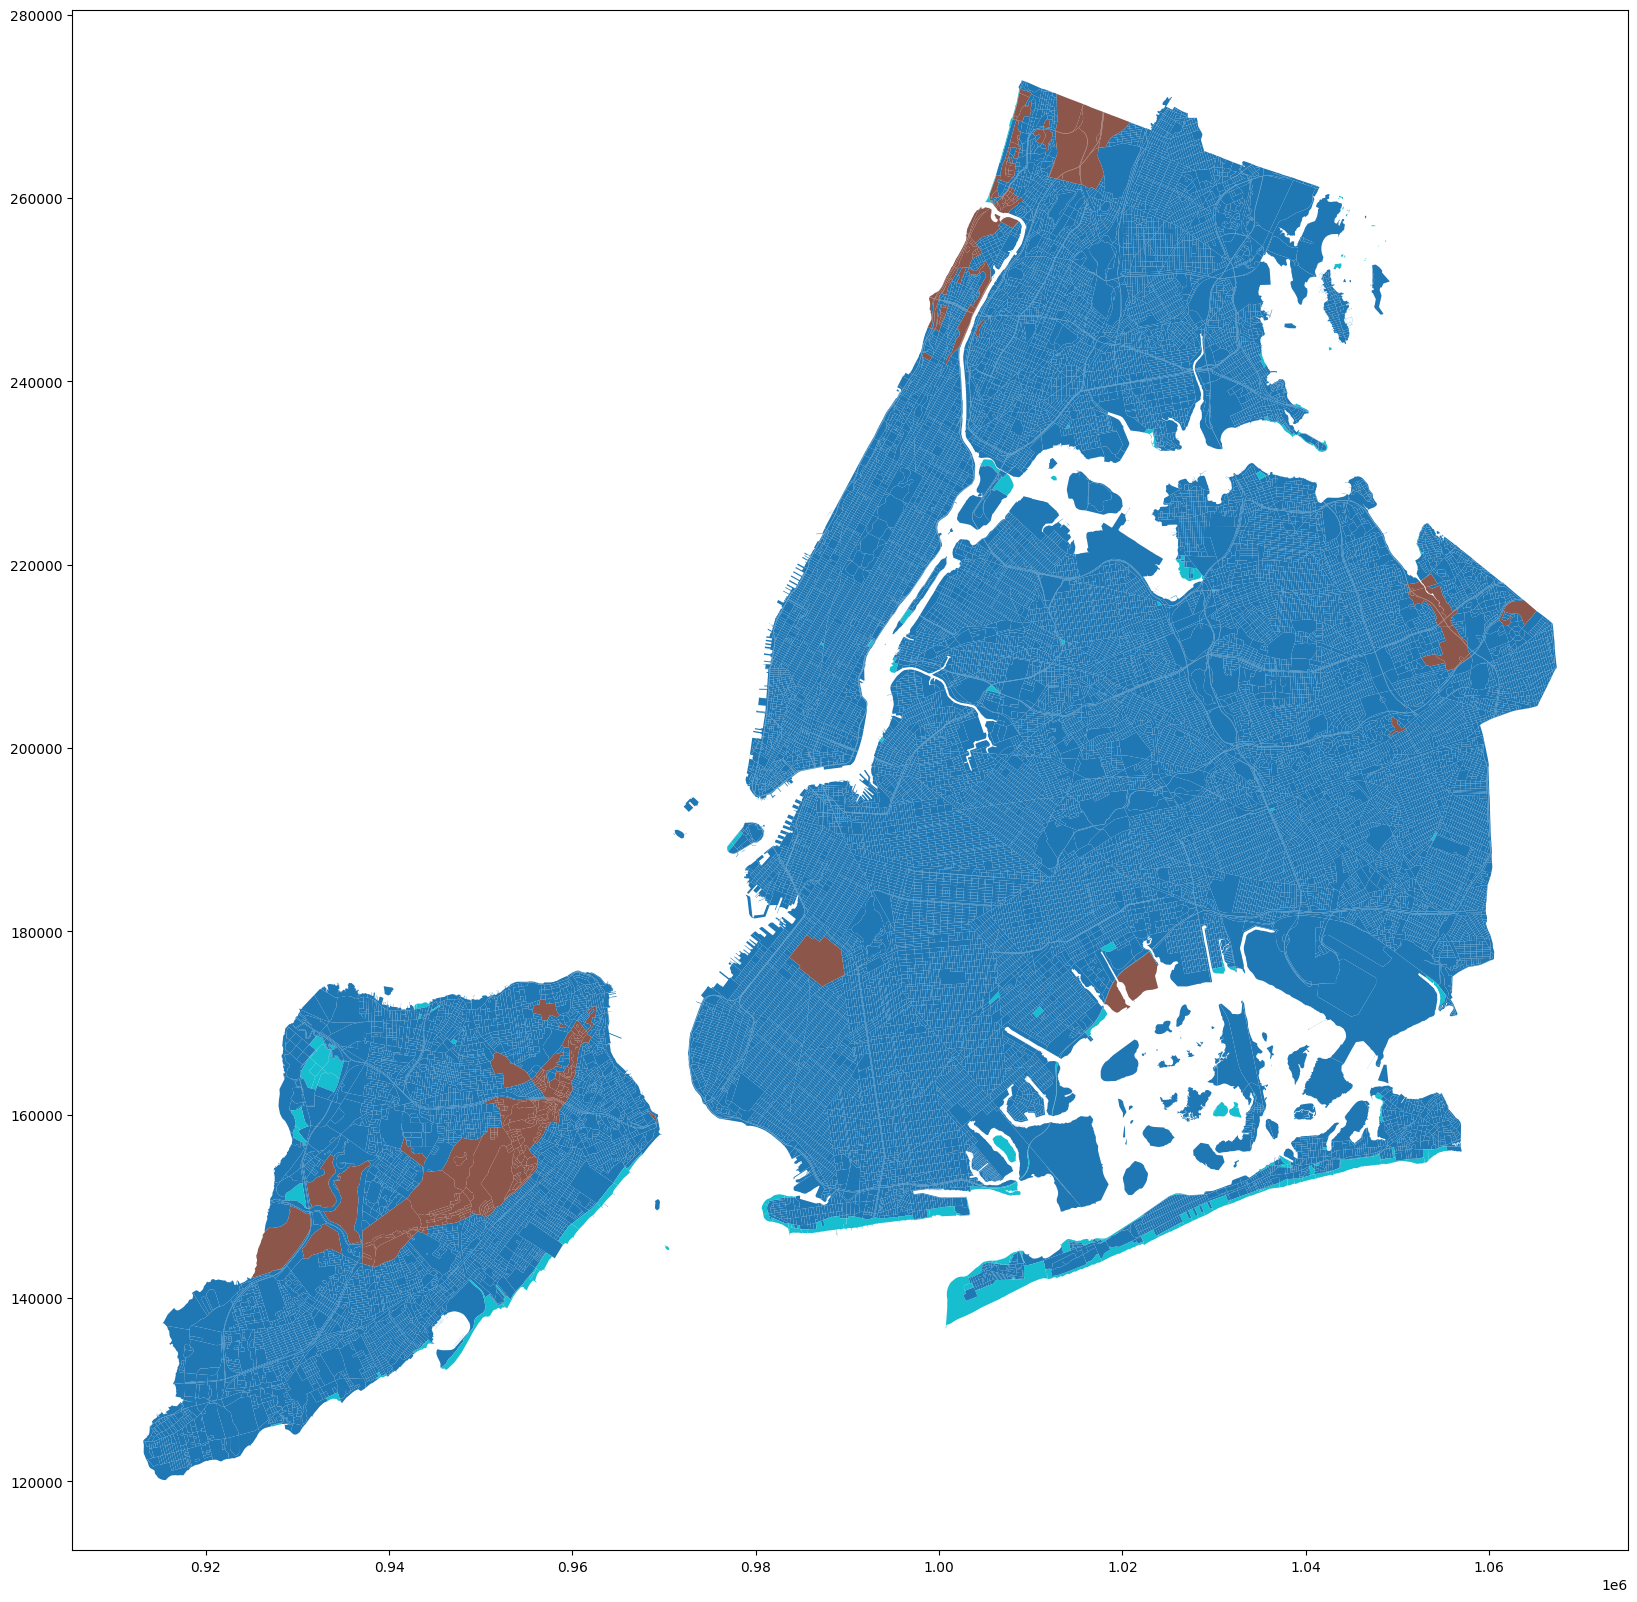

In [19]:
df.plot(column = 'cluster_3',
        categorical=True,
        figsize = (25, 20))

<AxesSubplot: >

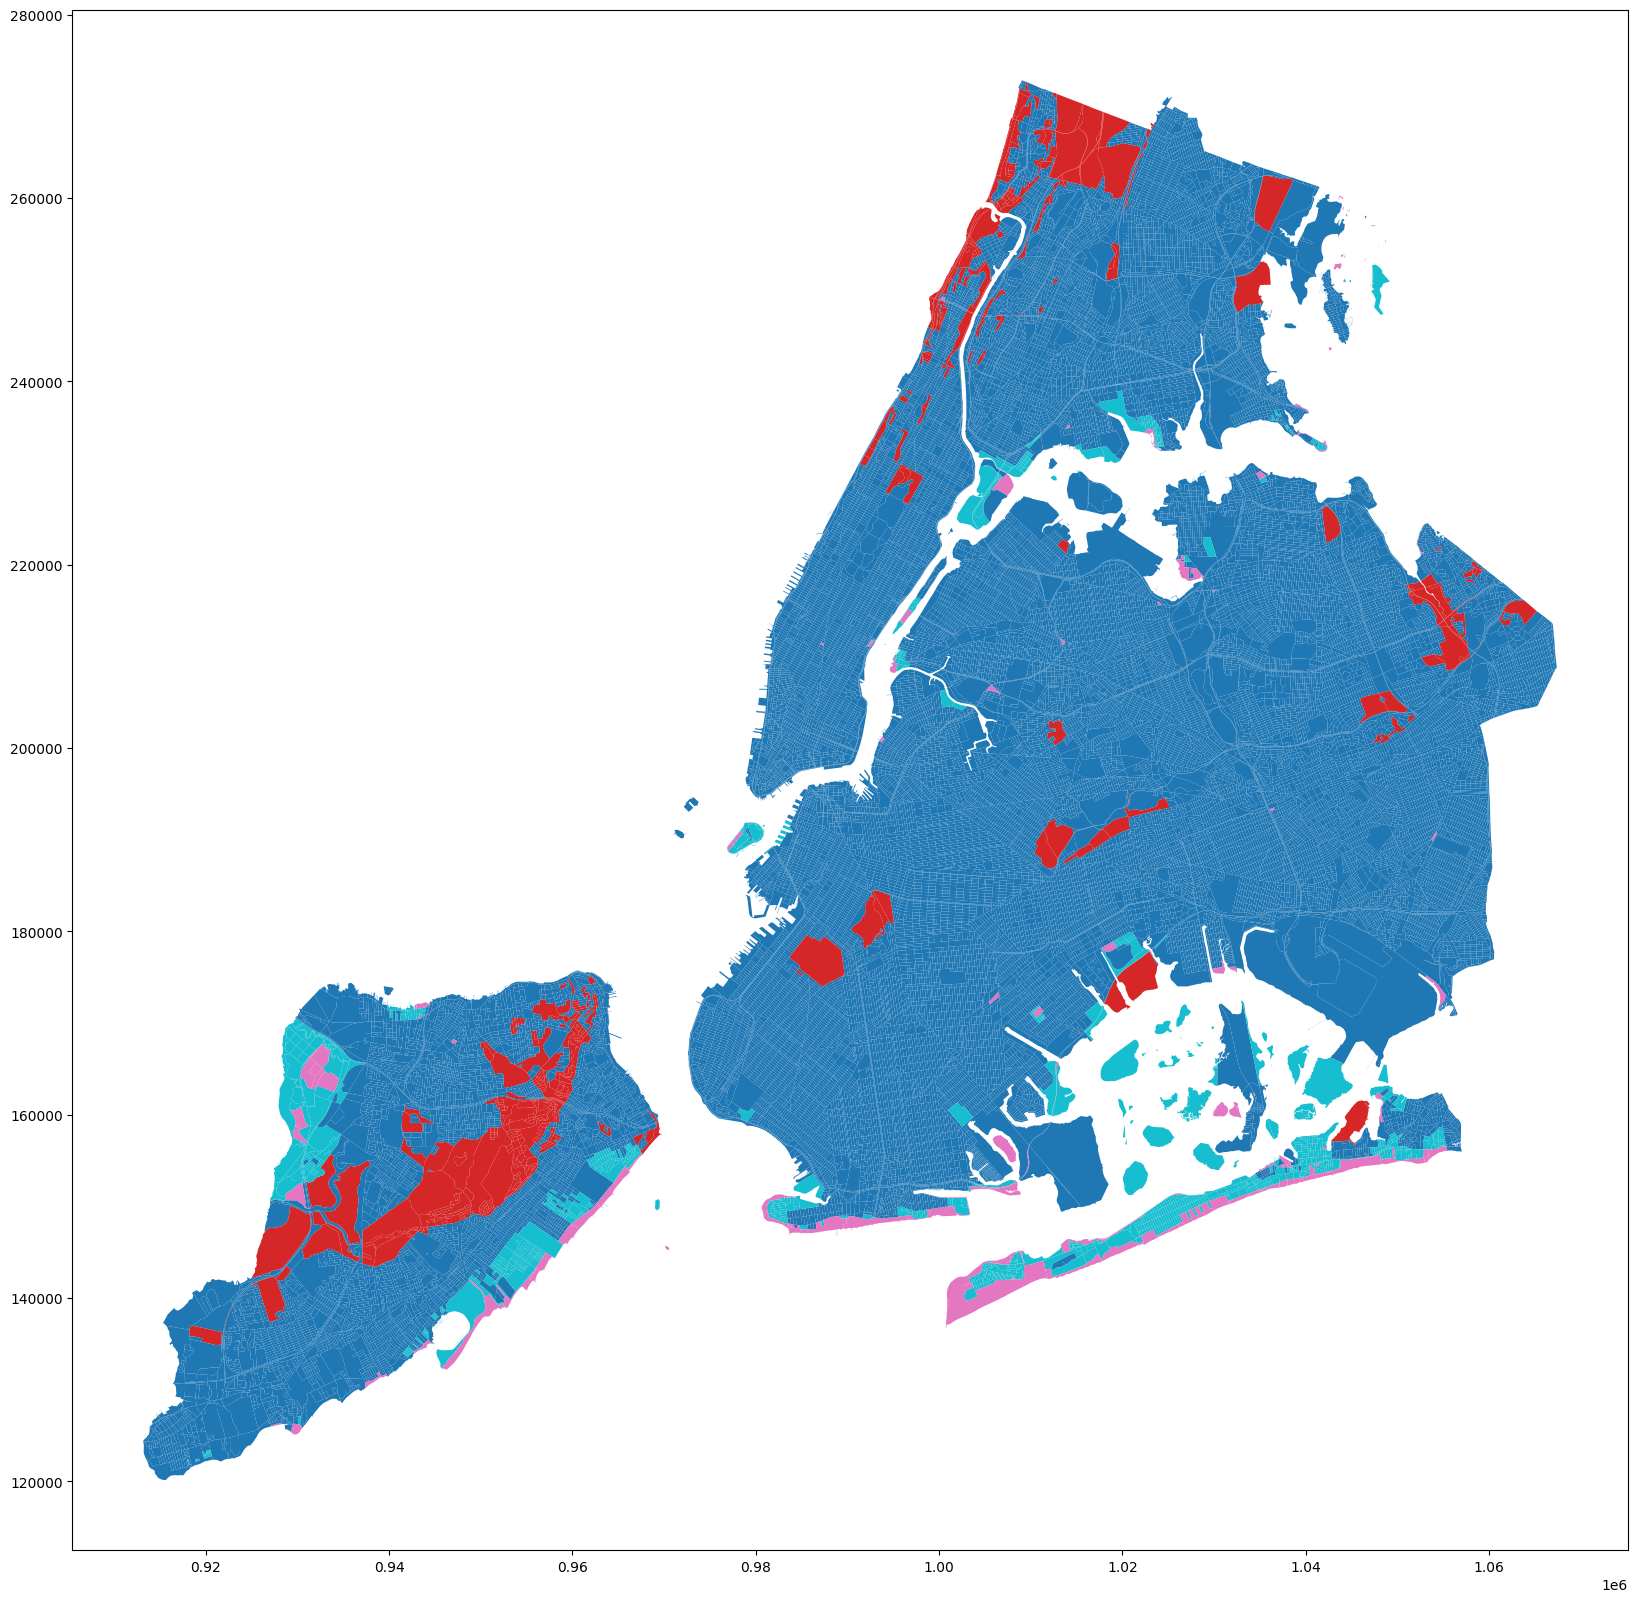

In [20]:
df.plot(column = 'cluster_4',
        categorical=True,
        figsize = (25, 20))

<AxesSubplot: >

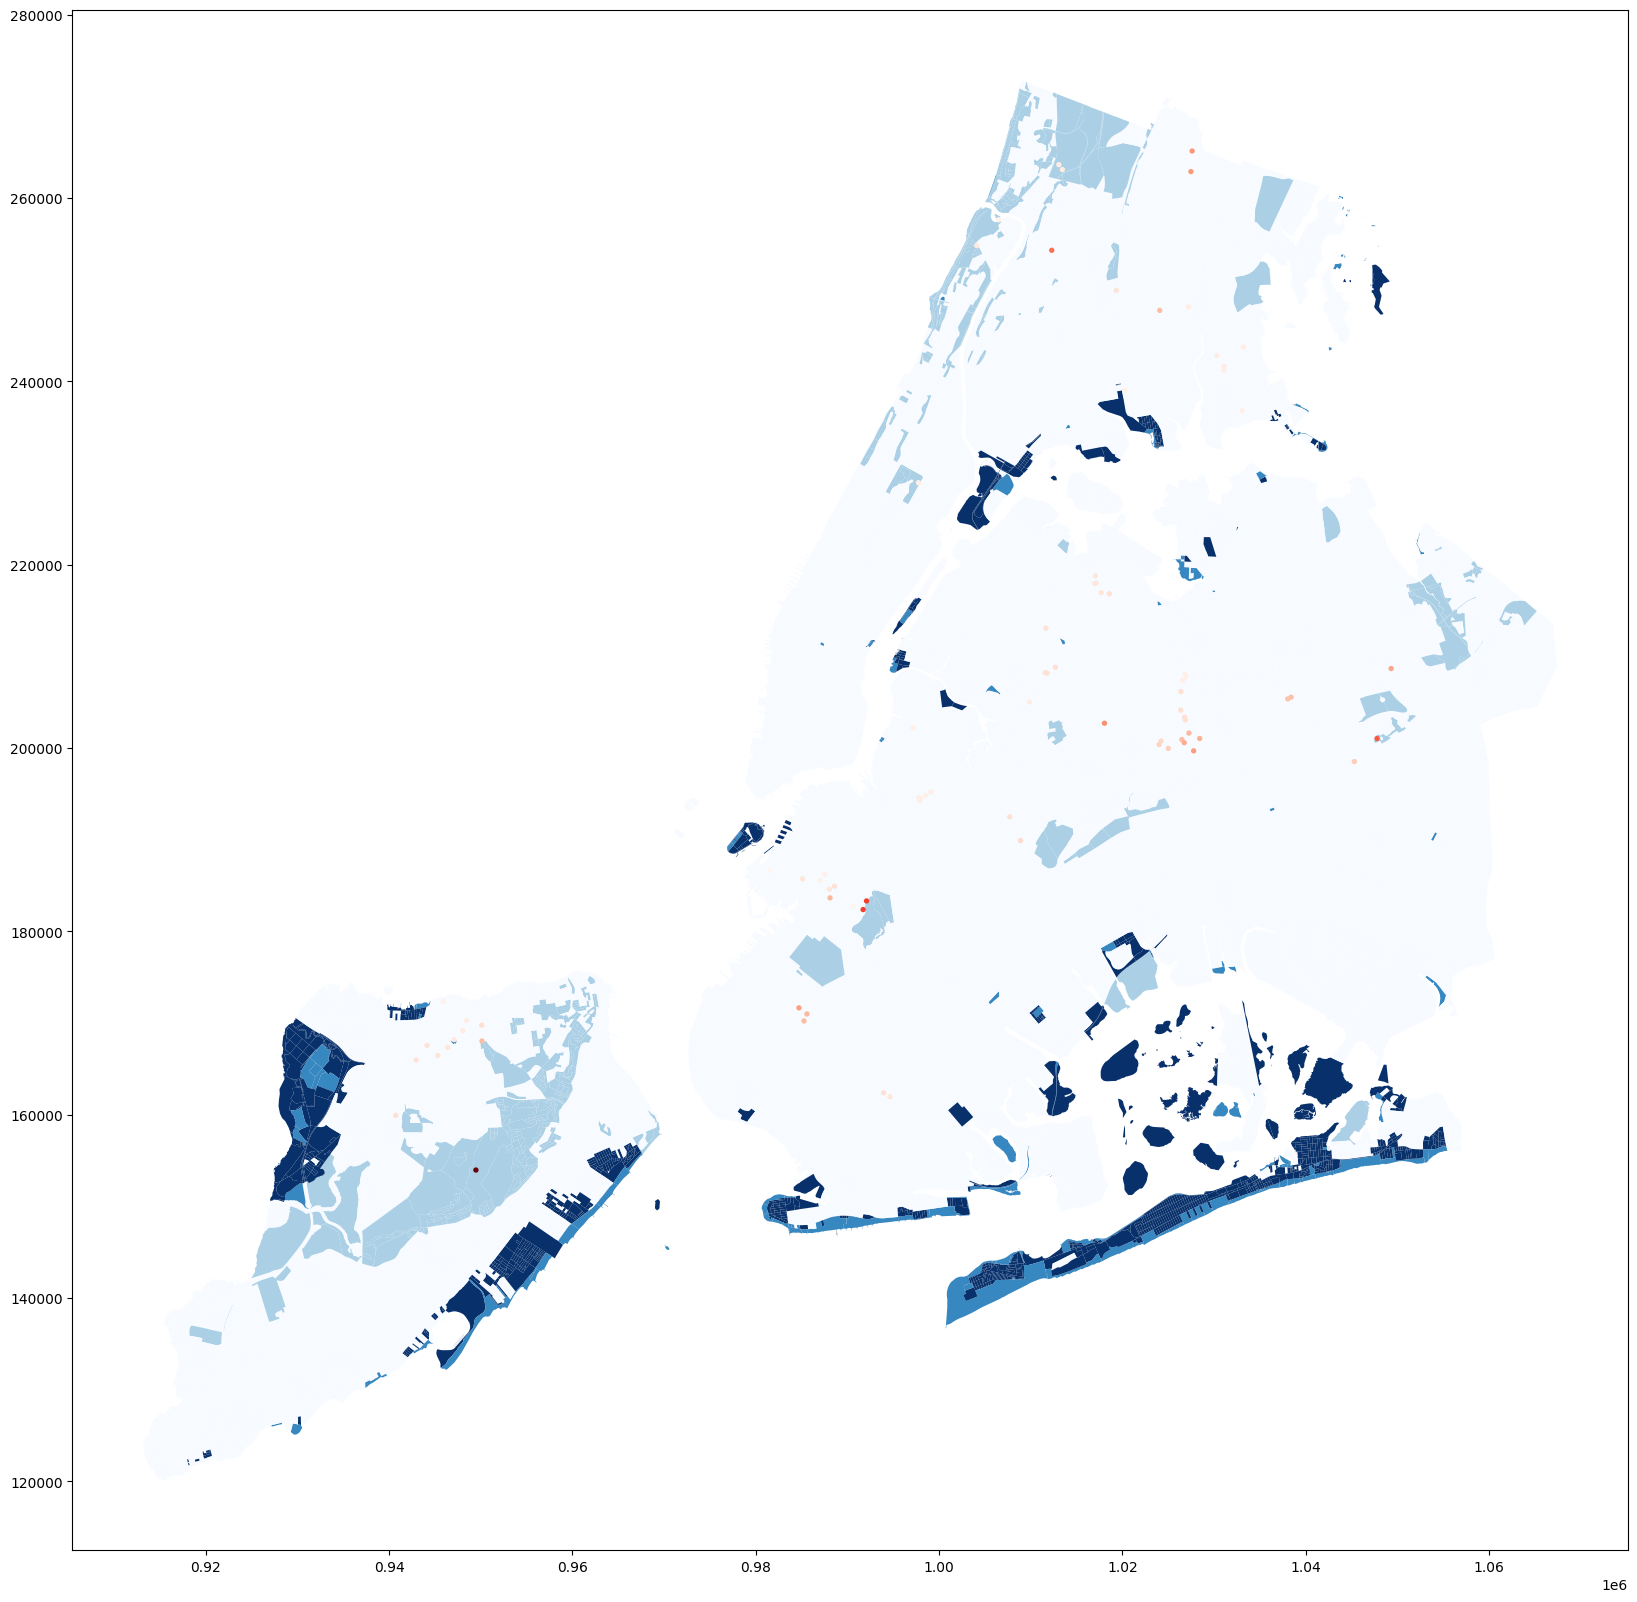

In [49]:
ax = df.plot('cluster_4',legend = False, figsize = (25,20), cmap ='Blues')
hw.plot('elev_ft',ax=ax, cmap = 'Reds', markersize = 8)

### Visualizations

In [21]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


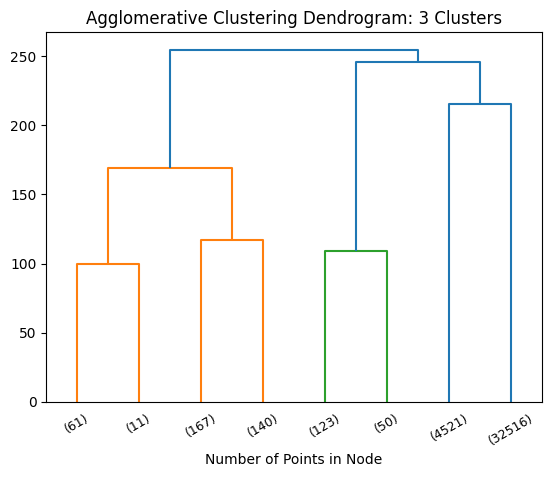

In [39]:
plt.title('Agglomerative Clustering Dendrogram: 3 Clusters')
plot_dendrogram(ac, truncate_mode = 'level', p = 2, leaf_rotation = 30, leaf_font_size = 9)
plt.xlabel('Number of Points in Node')
plt.show()